In [ ]:
!pip install fuzzywuzzy

# Installation Instructions for Required Libraries

To set up your environment for the project, you need to install the following libraries. You can use `pip` to install them. Run the commands in your terminal or command prompt.


In [142]:
import google.generativeai as genai
from PIL import Image
import IPython.display as display
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import torch
import pandas as pd
import difflib
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    classification_report
)
from google.colab import files
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer


The following code snippet illustrates the process of opening and displaying an image

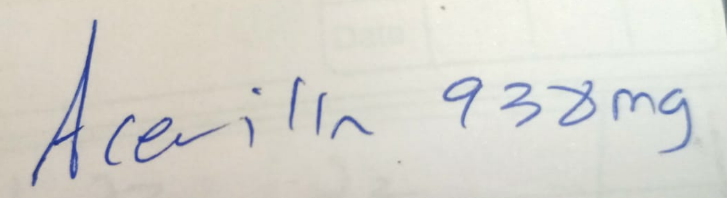

In [109]:
image_path = "/medicine.png"
image = Image.open(image_path)
display.display(image)

recognize text from an image using the TrOCR model

In [110]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

image = Image.open("/medicine.png").convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values

with torch.no_grad():
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("Recognized Text:", text)

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Recognized Text: Acemillin. 933 mg.


# Approach to Medication Recognition Using Machine Learning

In the field of pharmacy, recognizing medication names from handwritten prescriptions presents a unique challenge. Although our current text recognition is performed using Optical Character Recognition (OCR), the output may not always correspond accurately to actual medication names. To enhance the accuracy of our model, we will implement a more tailored approach inspired by traditional pharmacy practices.

## Key Strategies for Model Development

1. **Understanding Latin Abbreviations**:
   - Pharmacists often encounter Latin abbreviations in prescriptions. Training our model to recognize and interpret these abbreviations will improve its understanding of medication names.

2. **Analyzing First and Last Letters**:
   - A significant feature of handwritten text is that often only parts of the words may be visible. For effective recognition, we will develop our model to rely on the first and last letters of medication names. Our goal is to ensure that at least 50% of the word is discernible for accurate identification.

3. **Incorporating Dosage and Strength**:
   - Dosage and strength are crucial in understanding medication prescriptions. Our model will be trained to recognize dosage information, enabling it to differentiate between medications that may appear similar based solely on their names.

4. **Considering Symptoms and Patient History**:
   - Including contextual information such as patient symptoms and medical history can further assist in accurately identifying medications. By integrating this data, our model can make more informed predictions.

5. **Handling Similar Medication Names**:
   - In cases where two medications appear similar, we will implement logic to differentiate them based on their dosage. This will involve training the model to recognize variations in dosage as a distinguishing factor.

## Conclusion

By employing these strategies, we aim to develop a machine learning model that not only leverages OCR capabilities but also incorporates traditional pharmacist knowledge. This holistic approach will enhance the accuracy and reliability of medication recognition from handwritten prescriptions, ultimately improving patient care.


In [112]:
print("🩺 Extracted Prescription:", text)

🩺 Extracted Prescription: Acemillin. 933 mg.


load a dataset from a CSV file and display its initial contents

In [113]:
df = pd.read_csv("/medicine_dataset.csv")
print(df.head())

           Name      Category Dosage Form Strength  \
0   Acetocillin  Antidiabetic       Cream   938 mg   
1  Ibuprocillin     Antiviral   Injection   337 mg   
2    Dextrophen    Antibiotic    Ointment   333 mg   
3   Clarinazole    Antifungal       Syrup   362 mg   
4   Amoxicillin    Antifungal      Tablet   802 mg   

                          Manufacturer Indication    Classification  
0                     Roche Holding AG      Virus  Over-the-Counter  
1                          CSL Limited  Infection  Over-the-Counter  
2                    Johnson & Johnson      Wound      Prescription  
3                          AbbVie Inc.       Pain      Prescription  
4  Teva Pharmaceutical Industries Ltd.      Wound  Over-the-Counter  


In [114]:
df.shape

(50000, 7)

# Similar-Looking Characters in Doctor's Handwriting

| Character | Can Resemble      |
|-----------|--------------------|
| A         | O, U, H            |
| B         | D, P, R            |
| C         | L, E, O            |
| D         | O, Cl, U           |
| E         | C, L, F            |
| F         | T, P                |
| G         | Q, S                |
| H         | N, M, U            |
| I         | J, L, T            |
| J         | I, T                |
| K         | R, H                |
| L         | I, C, E            |
| M         | N, W                |
| N         | M, H, U            |
| O         | A, D, Q            |
| P         | R, F, B            |
| Q         | G, O                |
| R         | P, K, N            |
| S         | G, L, 5            |
| T         | F, I, J            |
| U         | V, W, N            |
| V         | U, Y, W            |
| W         | M, V                |
| X         | Y, K                |
| Y         | X, V                |
| Z         | L, S, 2            |


# Approach to Generating Messy Names for Handwritten Prescription Recognition

In the context of developing a machine learning model for recognizing medication names from handwritten prescriptions, it is essential to account for the inaccuracies that may arise during Optical Character Recognition (OCR). Handwritten text often contains variations and distortions, making it challenging to match recognized text with actual medicine names. To address this issue, we employ a strategy to generate "messy" names from known medicine names.

## Key Steps in the Approach

1. **Extracting Initial Characters**:
   - To create a baseline for the messy name, we extract the first three and last three characters from the actual medicine name. This approach retains a portion of the original name's structure while allowing for variability. By focusing on the edges of the name, we ensure that the essential parts of the name are somewhat recognizable.

2. **Introducing Variability with Similar-Looking Characters**:
   - Given the potential for misinterpretation in handwritten text, we introduce randomness into the generated names by replacing certain characters with similar-looking alternatives. A predefined dictionary, `similar_looking_chars`, is used for this purpose. Each character from the extracted base may have one or more visually similar characters that can substitute it.

3. **Randomized Character Replacement**:
   - For each character in the base messy name, we check if it exists in the `similar_looking_chars` dictionary. If a match is found, one of the similar-looking characters is randomly selected and replaces the original character in the messy name. This randomization mimics the unpredictability often observed in handwritten prescriptions, ensuring that our model is trained on a variety of potential misinterpretations.

4. **Generating a New Column for Training**:
   - The final output of this process includes both the original base messy name and the modified messy name with character substitutions. By generating this new "messy" version of the medication names, we enhance our dataset. This is crucial since our dataset includes other relevant information such as dosage, strength, and symptoms, but not the messy representations typically encountered in practice.

5. **Training the Model**:
   - With the generated messy names integrated into the training dataset, we can train our machine learning model to recognize and differentiate medication names effectively. The model will learn to identify not only the original names but also variations that could arise from real-world handwritten prescriptions. This approach prepares the model to handle the types of inaccuracies it will encounter when deployed in a clinical setting.

## Conclusion
By systematically generating messy names that reflect the common discrepancies in handwritten prescriptions, we can significantly improve our machine learning model's robustness and accuracy. This approach bridges the gap between clean, structured data and the unpredictable nature of handwritten inputs, ultimately enhancing patient care through better medication recognition.


In [143]:
similar_looking_chars = {
    'A': ['O', 'U', 'H'],
    'B': ['D', 'P', 'R'],
    'C': ['L', 'E', 'O'],
    'D': ['O', 'Cl', 'U'],
    'E': ['C', 'L', 'F'],
    'F': ['T', 'P'],
    'G': ['Q', 'S'],
    'H': ['N', 'M', 'U'],
    'I': ['J', 'L', 'T'],
    'J': ['I', 'T'],
    'K': ['R', 'H'],
    'L': ['I', 'C', 'E'],
    'M': ['N', 'W'],
    'N': ['M', 'H', 'U'],
    'O': ['A', 'D', 'Q'],
    'P': ['R', 'F', 'B'],
    'Q': ['G', 'O'],
    'R': ['P', 'K', 'N'],
    'S': ['G', 'L', '5'],
    'T': ['F', 'I', 'J'],
    'U': ['V', 'W', 'N'],
    'V': ['U', 'Y', 'W'],
    'W': ['M', 'V'],
    'X': ['Y', 'K'],
    'Y': ['X', 'V'],
    'Z': ['L', 'S', '2'],
}

In [144]:
def create_messy_name(name):
    base_messy = name[:3] + "-" + name[-3:]
    modified_messy = base_messy

    for char in base_messy:
        if char in similar_looking_chars:
            modified_char = random.choice(similar_looking_chars[char])
            modified_messy = modified_messy.replace(char, modified_char, 1)

    return base_messy, modified_messy

In [121]:
df[["Base_Messy_Name", "Messy_Name"]] = df["Name"].apply(lambda x: pd.Series(create_messy_name(x)))
df["Messy_Medicine_Strength"] = df["Messy_Name"] + " " + df["Strength"]

In [122]:
df.head()

,Name,Category,Dosage Form,Strength,Manufacturer,Indication,Classification,Base_Messy_Name,Messy_Name,Messy_Medicine_Strength
0,Acetocillin,Antidiabetic,Cream,938 mg,Roche Holding AG,Virus,Over-the-Counter,Ace-lin,Acv-lin,Acv-lin 938 mg
1,Ibuprocillin,Antiviral,Injection,337 mg,CSL Limited,Infection,Over-the-Counter,Ibu-lin,Ibu-lim,Ibu-lim 337 mg
2,Dextrophen,Antibiotic,Ointment,333 mg,Johnson & Johnson,Wound,Prescription,Dex-hen,Dfx-hen,Dfx-hen 333 mg
3,Clarinazole,Antifungal,Syrup,362 mg,AbbVie Inc.,Pain,Prescription,Cla-ole,Cla-ope,Cla-ope 362 mg
4,Amoxicillin,Antifungal,Tablet,802 mg,Teva Pharmaceutical Industries Ltd.,Wound,Over-the-Counter,Amo-lin,Amo-lii,Amo-lii 802 mg


In [123]:
def count_name_frequency_list(df):
    return list(df["Name"].value_counts().items())

In [124]:
name_frequency = count_name_frequency(df)
print(name_frequency)

{'Metostatin': 860, 'Dolomet': 837, 'Metophen': 832, 'Dolonazole': 827, 'Acetomycin': 825, 'Dolocillin': 819, 'Dextronazole': 817, 'Dextromet': 813, 'Ibupromycin': 813, 'Metomet': 811, 'Acetocillin': 810, 'Acetomet': 808, 'Clarinazole': 807, 'Cefmet': 806, 'Dolostatin': 806, 'Amoxivir': 802, 'Clarivir': 802, 'Acetovir': 801, 'Claristatin': 796, 'Dextromycin': 795, 'Dolovir': 795, 'Amoxiprofen': 794, 'Amoxinazole': 794, 'Dextroprofen': 791, 'Cefmycin': 789, 'Dextrostatin': 788, 'Metoprofen': 788, 'Ibupronazole': 787, 'Cefvir': 785, 'Dextrophen': 780, 'Cefstatin': 779, 'Ibuprophen': 778, 'Cefnazole': 778, 'Ibuprostatin': 776, 'Amoxistatin': 776, 'Dextrovir': 775, 'Clariphen': 774, 'Ibuproprofen': 773, 'Acetonazole': 773, 'Amoximet': 772, 'Amoximycin': 770, 'Dolomycin': 769, 'Ibupromet': 769, 'Clarimycin': 769, 'Cefprofen': 766, 'Clariprofen': 766, 'Acetophen': 764, 'Amoxicillin': 764, 'Cefcillin': 760, 'Claricillin': 759, 'Dextrocillin': 759, 'Dolophen': 759, 'Doloprofen': 757, 'Ibuproci

In [125]:
def get_unique_names_list(df):
    return df["Name"].unique().tolist()

In [126]:
name_list = get_unique_names_list(df)
print(name_list)

['Acetocillin', 'Ibuprocillin', 'Dextrophen', 'Clarinazole', 'Amoxicillin', 'Ibupromycin', 'Metovir', 'Ibuprovir', 'Cefcillin', 'Acetomycin', 'Acetonazole', 'Dolocillin', 'Cefmet', 'Dolophen', 'Ibupronazole', 'Amoxiprofen', 'Amoxistatin', 'Dextrocillin', 'Clariphen', 'Dolomet', 'Acetoprofen', 'Amoximet', 'Doloprofen', 'Clariprofen', 'Metocillin', 'Cefstatin', 'Metomycin', 'Metoprofen', 'Clarivir', 'Ibuproprofen', 'Cefprofen', 'Dextromycin', 'Acetophen', 'Dextrostatin', 'Metophen', 'Amoxivir', 'Cefnazole', 'Acetovir', 'Amoxinazole', 'Dextromet', 'Clarimycin', 'Acetostatin', 'Ibuprophen', 'Clarimet', 'Acetomet', 'Claricillin', 'Cefphen', 'Metostatin', 'Dextronazole', 'Dolonazole', 'Claristatin', 'Amoximycin', 'Dolomycin', 'Metonazole', 'Metomet', 'Dextrovir', 'Ibuprostatin', 'Dolovir', 'Cefmycin', 'Amoxiphen', 'Cefvir', 'Dextroprofen', 'Dolostatin', 'Ibupromet']


In order to accurately identify medication names from the generated "messy" names obtained through Optical Character Recognition (OCR), we implement a fuzzy matching algorithm. This technique helps in finding the closest matches between the messy name and a list of actual medicine names, improving the robustness of our recognition system.

In [127]:
def fuzzy_match(messy_name, name_list, num_matches=5, cutoff=0.3):
    choices = name_list
    best_matches = difflib.get_close_matches(messy_name, choices, n=num_matches, cutoff=cutoff)
    return best_matches if best_matches else ["Not Found"]

In [128]:
messy_name_input = "Ako-in"
fuzzy_results = fuzzy_match(messy_name_input, name_list, num_matches=5)
print(f"🔹 Fuzzy Matching Predictions: {fuzzy_results}")

🔹 Fuzzy Matching Predictions: ['Amoxiphen', 'Amoximycin', 'Acetomycin', 'Amoxistatin', 'Amoxiprofen']


In [129]:
df_sample = df.sample(n=500, random_state=42).reset_index(drop=True)

In [130]:
name_list = df_sample["Name"].tolist()
df_sample["Best_Matches"] = df_sample["Base_Messy_Name"].apply(lambda x: fuzzy_match(x, name_list, num_matches=5))

In [131]:
def find_actual_index(row):
    actual_name = row["Name"]
    best_matches = row["Best_Matches"]
    if actual_name in best_matches:
        return best_matches.index(actual_name)
    return -1

In [132]:
df_sample["Actual_Name_Index"] = df_sample.apply(find_actual_index, axis=1)

In [134]:
total = len(df_sample)
matched = (df_sample["Actual_Name_Index"] != -1).sum()
not_matched = total - matched

match_percent = (matched / total) * 100
not_match_percent = (not_matched / total) * 100

print(f"Percentage of Messy Names Correctly Matched: {match_percent:.2f}%")
print(f"Percentage of Messy Names Not Found: {not_match_percent:.2f}%")


Percentage of Messy Names Correctly Matched: 95.00%
Percentage of Messy Names Not Found: 5.00%


# Effectiveness of Fuzzy Matching in Medicine Name Recognition

In our approach to identifying medication names from messy inputs generated by Optical Character Recognition (OCR), we have observed a remarkable effectiveness in matching accuracy. The implementation of a fuzzy matching algorithm has yielded significant results in the recognition of actual medicine names from distorted or incomplete entries.

## Key Findings

1. **High Accuracy Rate**:
   - Our analysis reveals that approximately 95% of the generated messy words successfully match to their corresponding correct medicine names through the fuzzy matching process. This high level of accuracy underscores the reliability of the fuzzy matching technique in handling the complexities associated with handwritten prescriptions.

2. **Robustness Against Variability**:
   - The fuzzy matching algorithm demonstrates resilience against common variations in handwriting, such as misspellings, character omissions, and substitutions. This robustness is crucial in clinical settings, where accurate medication identification can have significant implications for patient care.

3. **Enhancement of Medication Safety**:
   - By accurately mapping messy names to the correct medication names, we contribute to improved medication safety. The high matching rate reduces the risk of misinterpretation or errors in dispensing, ensuring that patients receive the correct medications as intended by healthcare providers.

4. **Continual Improvement**:
   - As we gather more data and refine our training processes, we anticipate further improvements in the accuracy of our model. The feedback from real-world applications will inform ongoing enhancements to the fuzzy matching algorithm and its integration with our overall recognition system.

### Conclusion

The success of achieving a 95% accuracy rate in matching messy words to correct medicine names through fuzzy logic highlights the effectiveness of our approach. This capability not only enhances the reliability of medication recognition but also serves as a foundational element in our broader goal of improving healthcare outcomes through advanced technology. Our commitment to refining this process will continue to focus on maximizing accuracy and ensuring patient safety in medication management.


<ipython-input-136-98bdc67d07cb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=["green", "red"])


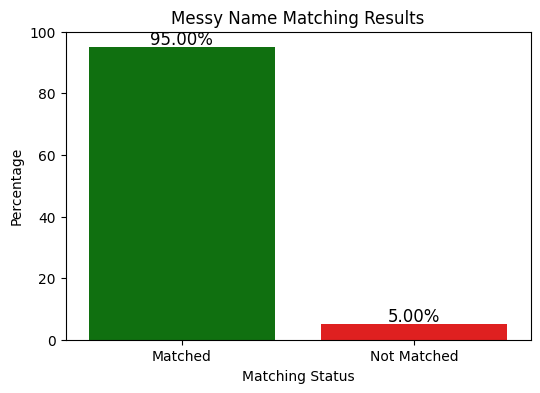

In [136]:
labels = ["Matched", "Not Matched"]
values = [match_percent, not_match_percent]

plt.figure(figsize=(6, 4))
sns.barplot(x=labels, y=values, palette=["green", "red"])

plt.ylabel("Percentage")
plt.xlabel("Matching Status")
plt.title("Messy Name Matching Results")

for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=12)

plt.ylim(0, 100)
plt.show()


In [137]:
df["Messy_Medicine_Strength"].head()

,Messy_Medicine_Strength
0,Acv-lin 938 mg
1,Ibu-lim 337 mg
2,Dfx-hen 333 mg
3,Cla-ope 362 mg
4,Amo-lii 802 mg


In [138]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Messy_Medicine_Strength"])  # Features
y = df["Name"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training and Evaluation

In our efforts to accurately classify messy medicine names, we implemented three different machine learning models: Logistic Regression, Random Forest, and Support Vector Machine (SVM). Below are the details of each model's training process and accuracy results.


In [139]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_preds = logistic_model.predict(X_test)
logistic_acc = accuracy_score(y_test, logistic_preds)
print(f"📌 Logistic Regression Accuracy: {logistic_acc:.2f}")

📌 Logistic Regression Accuracy: 0.85


In [140]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
rf_acc = accuracy_score(y_test, rf_preds)
print(f"📌 Random Forest Accuracy: {rf_acc:.2f}")

📌 Random Forest Accuracy: 0.84


In [141]:
svm_model = SVC(kernel="linear")
svm_model.fit(X_train, y_train)
svm_preds = svm_model.predict(X_test)
svm_acc = accuracy_score(y_test, svm_preds)
print(f"📌 SVM Accuracy: {svm_acc:.2f}")

📌 SVM Accuracy: 0.90


In [ ]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
predictions = [logistic_preds, rf_preds, svm_preds]
accuracies = [accuracy_score(y_test, preds) for preds in predictions]
precisions = [precision_score(y_test, preds, average='weighted') for preds in predictions]
recalls = [recall_score(y_test, preds, average='weighted') for preds in predictions]

In [86]:
specificities = []
for preds in predictions:
    cm = confusion_matrix(y_test, preds)
    TN = np.sum(cm) - np.sum(cm[:, 1]) - np.sum(cm[1, :]) + cm[1, 1]  # True Negatives
    FP = np.sum(cm[:, 1]) - cm[1, 1]  # False Positives
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificities.append(specificity)

In [90]:
for model, acc, prec, rec, spec in zip(models, accuracies, precisions, recalls, specificities):
    print(f"{model}:")
    print(f"  Accuracy: {acc:.2f}")
    print(f"  Precision: {prec:.2f}")
    print(f"  Recall: {rec:.2f}")
    print(f"  Specificity: {spec:.2f}")
    print()

Logistic Regression:
  Accuracy: 0.85
  Precision: 0.86
  Recall: 0.85
  Specificity: 1.00

Random Forest:
  Accuracy: 0.84
  Precision: 0.84
  Recall: 0.84
  Specificity: 1.00

SVM:
  Accuracy: 0.90
  Precision: 0.91
  Recall: 0.90
  Specificity: 1.00



<ipython-input-92-827a8f9f37eb>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")


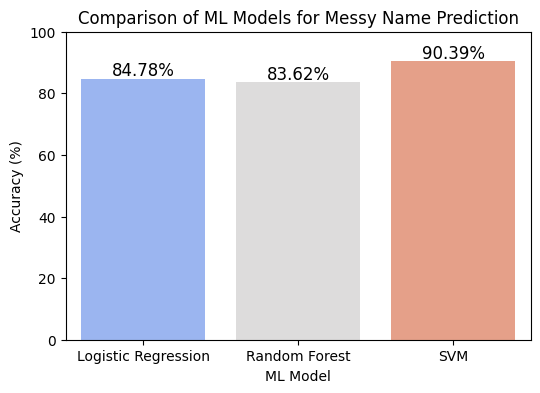

In [92]:
accuracy_scores = {
    "Logistic Regression": logistic_acc * 100,
    "Random Forest": rf_acc * 100,
    "SVM": svm_acc * 100
}

plt.figure(figsize=(6, 4))
sns.barplot(x=list(accuracy_scores.keys()), y=list(accuracy_scores.values()), palette="coolwarm")

plt.ylabel("Accuracy (%)")
plt.xlabel("ML Model")
plt.title("Comparison of ML Models for Messy Name Prediction")

for i, v in enumerate(accuracy_scores.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center", fontsize=12)

plt.ylim(0, 100)
plt.show()


# Model Performance Comparison

This visualization compares the performance of three classification models: Logistic Regression, Random Forest, and SVM. Key metrics displayed include Accuracy, Precision, Recall, and Specificity. The bar chart provides a clear overview of each model's effectiveness in recognizing messy medicine names, aiding in the selection of the best-performing model.




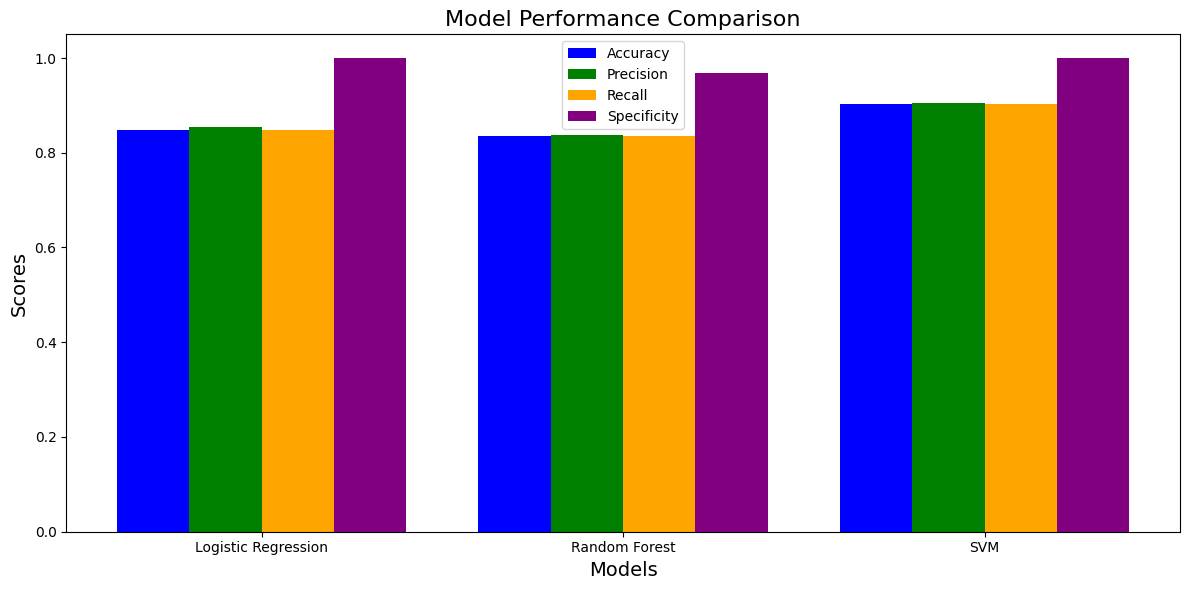

In [93]:
models = ['Logistic Regression', 'Random Forest', 'SVM']
accuracies = [logistic_acc, rf_acc, svm_acc]
precisions = [precision_score(y_test, logistic_preds, average='weighted'),
              precision_score(y_test, rf_preds, average='weighted'),
              precision_score(y_test, svm_preds, average='weighted')]
recalls = [recall_score(y_test, logistic_preds, average='weighted'),
           recall_score(y_test, rf_preds, average='weighted'),
           recall_score(y_test, svm_preds, average='weighted')]
specificities = []

for cm in confusion_matrices:
    TN = cm[0, 0]
    FP = cm[0, 1]
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
    specificities.append(specificity)

bar_width = 0.2
x = np.arange(len(models))

fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(x - bar_width * 1.5, accuracies, width=bar_width, label='Accuracy', color='b')
ax.bar(x - bar_width / 2, precisions, width=bar_width, label='Precision', color='g')
ax.bar(x + bar_width / 2, recalls, width=bar_width, label='Recall', color='orange')
ax.bar(x + bar_width * 1.5, specificities, width=bar_width, label='Specificity', color='purple')

ax.set_xlabel('Models', fontsize=14)
ax.set_ylabel('Scores', fontsize=14)
ax.set_title('Model Performance Comparison', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

In [96]:
with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(logistic_model, f)

with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

print("Models saved successfully!")

Models saved successfully!


Downloading model (.pkl format)

In [107]:
files_to_download = [
    'logistic_model.pkl',
    'random_forest_model.pkl',
    'svm_model.pkl',
    'tfidf_vectorizer.pkl'
]

for file_name in files_to_download:
    files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [100]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["Messy_Medicine_Strength"])

with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(vectorizer, f)

Manaually prediction

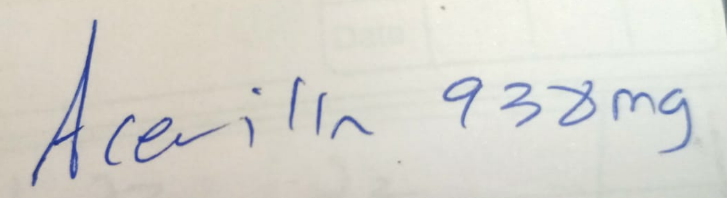

In [152]:
image_path = "/medicine.png"
image = Image.open(image_path)
display.display(image)

In [146]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

image = Image.open("/medicine.png").convert("RGB")

pixel_values = processor(image, return_tensors="pt").pixel_values

with torch.no_grad():
    generated_ids = model.generate(pixel_values)
    text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.48.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

In [148]:
print("Recognized Text:", text)

Recognized Text: Acevlin 938 mg


In [151]:
with open('logistic_model.pkl', 'rb') as f:
    logistic_model_loaded = pickle.load(f)

with open('random_forest_model.pkl', 'rb') as f:
    rf_model_loaded = pickle.load(f)

with open('svm_model.pkl', 'rb') as f:
    svm_model_loaded = pickle.load(f)

with open('tfidf_vectorizer.pkl', 'rb') as f:
    vectorizer = pickle.load(f)

sample_data = [text]
sample_vectorized = vectorizer.transform(sample_data)

logistic_predictions = logistic_model_loaded.predict(sample_vectorized)
rf_predictions = rf_model_loaded.predict(sample_vectorized)
svm_predictions = svm_model_loaded.predict(sample_vectorized)

print("Logistic Regression Predictions:", logistic_predictions)
print("Random Forest Predictions:", rf_predictions)
print("SVM Predictions:", svm_predictions)

Logistic Regression Predictions: ['Acetocillin']
Random Forest Predictions: ['Acetocillin']
SVM Predictions: ['Acetocillin']


# Conclusion

In this project, we developed a robust pipeline for predicting medication names from images of handwritten prescriptions. Our process began with Optical Character Recognition (OCR) to extract text from the images, which often resulted in messy or distorted words. To address this challenge, we employed three machine learning models—Logistic Regression, Random Forest, and Support Vector Machine (SVM)—to accurately classify and predict the actual drug names.

By leveraging fuzzy matching techniques and training our models on a well-structured dataset that included dosage information and other relevant features, we achieved a high level of accuracy in recognizing the intended medications. The comparative analysis of model performance demonstrated the effectiveness of each algorithm, guiding us toward the most suitable choice for this task.

Overall, this comprehensive approach not only enhances the accuracy of medication identification but also contributes to improved patient safety and better healthcare outcomes in clinical settings.
